# ARIMA Model Comparison With Data From Different Domains
This notebook demonstrates how to run the prediction models on financial data

ARIMA is represented by three parameters: p, d, and q:

p: The number of past values (lags) considered in the AR term.

d: The degree of differencing applied to the data.

q: The number of past forecast errors included in the MA term.

order = (p,d,q) order of the model for the autoregressive, differences, and moving average components. d is always an integer, while p and q may either be integers or lists of integers.


In [1]:
import sys
import os

%matplotlib inline

# Add the project root (one level up from 'notebooks') to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
# Imports from our src/ modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import autocorrelation_plot

from src.data.load_fin_data import load_finance_data, load_fred_data
from src.data.preprocess_fin_data import enrich_target_stock, flatten_cols
from src.data.make_dataset import train_test_split
from src.data.split_sequences import prepare_train_val_test
from src.models.base_ARIMA import run_arima_on_dataset

from src.evaluation.evaluate import evaluate_model
from src.evaluation.metrics import generate_model_metrics
from src.data.scaler_utils import get_scaler
from src.data.adjusted_r2 import adjusted_r2
from src.visualization.visualization import plot_heatmap

# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.preprocessing import RobustScaler

# from statsmodels.tsa.arima.model import ARIMA
# from math import sqrt

In [3]:
finance_data = pd.read_csv('../data/dataset_finance/processed/processed_finance_data.csv')

finance_data

,Date,Close_TSLA,Volume_TSLA,TSLA_Returns,TSLA_day,TSLA_month,TSLA_weekday,day_sin,day_cos,month_sin,...,Close_SOXX,Volume_SOXX,SOXX_Returns,PCE_Price_Index,Core_PCE_Price_Index,10-Year_Treasury_Yield,Federal_Funds_Rate,University_of_Michigan-Consumer_Sentiment,Consumer_Price_Index-All_Items-Total_for_United_States,Total_Vehicle_Sales
0,2014-09-17,17.425333,77665500.0,0.002454,17.0,9.0,2.0,-0.299363,-0.954139,-1.000000,...,26.093210,444000.0,0.007184,97.413,96.013,2.62,0.09,84.6,0.075257,16.959
1,2014-09-18,17.587999,55389000.0,0.009335,18.0,9.0,3.0,-0.485302,-0.874347,-1.000000,...,26.492056,355500.0,0.015285,97.413,96.013,2.63,0.09,84.6,0.075257,16.959
2,2014-09-19,17.288000,102163500.0,-0.017057,19.0,9.0,4.0,-0.651372,-0.758758,-1.000000,...,26.161163,339000.0,-0.012490,97.413,96.013,2.59,0.09,84.6,0.075257,16.959
3,2014-09-22,16.668667,123211500.0,-0.035824,22.0,9.0,0.0,-0.968077,-0.250653,-1.000000,...,25.845039,315600.0,-0.012084,97.413,96.013,2.57,0.09,84.6,0.075257,16.959
4,2014-09-23,16.694000,84880500.0,0.001520,23.0,9.0,1.0,-0.998717,-0.050649,-1.000000,...,25.762320,632700.0,-0.003201,97.413,96.013,2.54,0.09,84.6,0.075257,16.959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2373,2024-02-26,199.399994,111747100.0,0.038704,26.0,2.0,0.0,-0.848644,0.528964,0.866025,...,212.632172,3759000.0,0.009867,122.494,121.418,4.28,5.33,76.9,0.618967,16.177
2374,2024-02-27,199.729996,108645400.0,0.001655,27.0,2.0,1.0,-0.724793,0.688967,0.866025,...,212.420441,4560900.0,-0.000996,122.494,121.418,4.31,5.33,76.9,0.618967,16.177
2375,2024-02-28,202.039993,99806200.0,0.011566,28.0,2.0,2.0,-0.571268,0.820763,0.866025,...,210.031952,2923800.0,-0.011244,122.494,121.418,4.27,5.33,76.9,0.618967,16.177
2376,2024-02-29,201.880005,85907000.0,-0.000792,29.0,2.0,3.0,-0.394356,0.918958,0.866025,...,215.721985,3382800.0,0.027091,122.494,121.418,4.25,5.33,76.9,0.618967,16.177


[Before Model Training] Memory Usage: 453.58 MB | Peak Memory Usage: 459.46 MB | CPU Usage: 0.00%
Auto-selecting (p,d,q) using PMDARIMA...


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\d

Selected order: (5, 2, 0)


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

[After Model Training] Memory Usage: 476.46 MB | Peak Memory Usage: 551.45 MB | CPU Usage: 0.00%
Total Training Time: 59.71 seconds
Memory Used (MB): 22.88

[ARIMA - Finance] Evaluation Summary (Statsmodels ARIMA)
---------------------------------------------------------------------------
RMSE                : 1320.026
MSE                 : 1742469.671
MAE                 : 1113.220
MAPE (%)            : nan
R²                  : -528.778
Adjusted R²         : -597.624
Training Time (s)   : 59.71
Memory Used (MB)    : 22.88
Device Used         : CPU
---------------------------------------------------------------------------


c:\Users\gnniv\Documents\NUS Msc In Data Science in Sustainability\DSS5104 Machine Learning and Predictive Modelling\CA2\ProjectFiles\GitHub\DSS5104-ForecastDL\src\models\base_ARIMA.py:145: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100


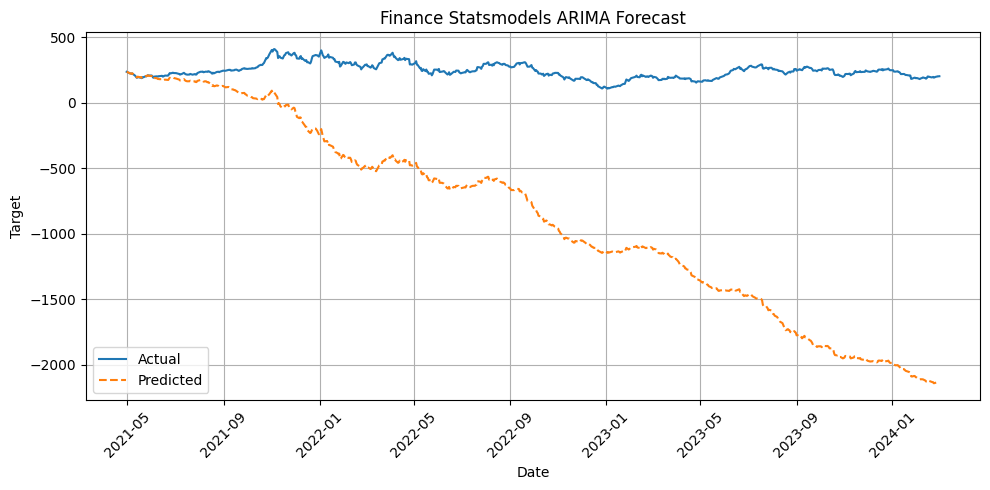

{'Dataset': 'Finance',
 'Model': 'Statsmodels ARIMA',
 'Target': 'Close_TSLA',
 'RMSE': 1320.0263902019033,
 'MSE': 1742469.6708294675,
 'MAE': 1113.2196087268828,
 'MAPE': nan,
 'R²': -528.7779725394032,
 'Adj_R²': -597.6239214272496,
 'TrainingTime_s': 59.707242250442505,
 'TestRatio': 0.3,
 'Device': 'CPU',
 'FinalMemoryMB': 476.45703125}

In [4]:
# Run ARIMA Model on Finance Data

# Define parameters for ARIMA model
finance_data.name = "Finance"
target = "Close_TSLA"  # Target variable to predict
date_col = "Date"  # Column name for the date
test_ratio = 0.3  # Proportion of data to use for testing
engine = "statsmodels" # Engine to use for ARIMA model # or "pmdarima"
order=None  # ARIMA order (p, d, q)

finance_arima_results = run_arima_on_dataset(
    finance_data,
    target,
    date_col,
    test_ratio,
    engine,  
    order
)

finance_arima_results

In [5]:
# load parquet data to pandas dataframe
retail_data = pd.read_parquet('../data/dataset_retail/processed/data_with_lags_s1_i1.parquet')
retail_data	= retail_data.drop(columns=['split'])

retail_data

,date,sales,year,month,day,dayofweek,dayofyear,weekofyear,quarter,is_month_start,...,sales_roll_mean_60d,sales_roll_std_60d,sales_roll_median_60d,sales_roll_min_60d,sales_roll_max_60d,sales_roll_mean_90d,sales_roll_std_90d,sales_roll_median_90d,sales_roll_min_90d,sales_roll_max_90d
0,2014-01-01,9,2014,1,1,2,1,1,1,1,...,15.416667,5.645732,16.0,5.0,31.0,15.733333,5.120569,16.0,5.0,31.0
1,2014-01-02,14,2014,1,2,3,2,1,1,0,...,15.333333,5.628820,16.0,5.0,31.0,15.733333,5.120569,16.0,5.0,31.0
2,2014-01-03,11,2014,1,3,4,3,1,1,0,...,15.316667,5.640326,16.0,5.0,31.0,15.700000,5.141700,16.0,5.0,31.0
3,2014-01-04,20,2014,1,4,5,4,1,1,0,...,15.316667,5.640326,16.0,5.0,31.0,15.700000,5.141700,16.0,5.0,31.0
4,2014-01-05,17,2014,1,5,6,5,1,1,0,...,15.333333,5.643856,16.0,5.0,31.0,15.744444,5.135383,16.0,5.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2017-12-27,14,2017,12,27,2,361,52,4,0,...,19.866667,6.261171,19.0,6.0,34.0,20.193182,5.908999,20.0,6.0,34.0
1457,2017-12-28,19,2017,12,28,3,362,52,4,0,...,19.700000,6.145965,19.0,6.0,34.0,20.179775,5.876691,20.0,6.0,34.0
1458,2017-12-29,15,2017,12,29,4,363,52,4,0,...,19.583333,6.167964,19.0,6.0,34.0,20.122222,5.869035,20.0,6.0,34.0
1459,2017-12-30,27,2017,12,30,5,364,52,4,0,...,19.633333,6.216344,19.0,6.0,34.0,20.188889,5.913030,20.0,6.0,34.0


[Before Model Training] Memory Usage: 470.72 MB | Peak Memory Usage: 551.45 MB | CPU Usage: 0.00%
Auto-selecting (p,d,q) using PMDARIMA...


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\d

Selected order: (4, 1, 5)


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[After Model Training] Memory Usage: 490.10 MB | Peak Memory Usage: 596.90 MB | CPU Usage: 0.00%
Total Training Time: 79.23 seconds
Memory Used (MB): 19.38

[ARIMA - Retail] Evaluation Summary (Statsmodels ARIMA)
---------------------------------------------------------------------------
RMSE                : 88.932
MSE                 : 7908.814
MAE                 : 68.400
MAPE (%)            : 392.065
R²                  : -172.064
Adjusted R²         : -193.401
Training Time (s)   : 79.23
Memory Used (MB)    : 19.38
Device Used         : CPU
---------------------------------------------------------------------------


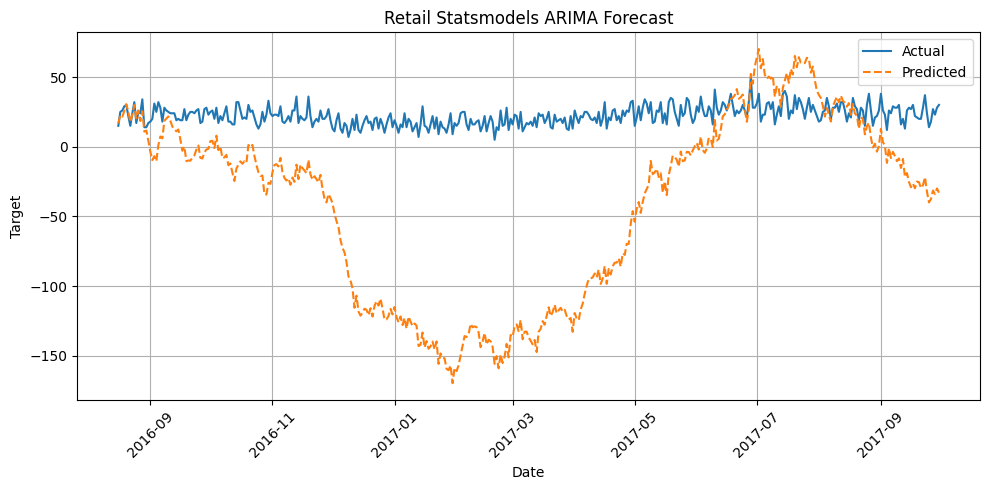

{'Dataset': 'Retail',
 'Model': 'Statsmodels ARIMA',
 'Target': 'sales',
 'RMSE': 88.93151239133813,
 'MSE': 7908.813896210729,
 'MAE': 68.3995692700736,
 'MAPE': 392.0645945742936,
 'R²': -172.06408620293237,
 'Adj_R²': -193.40075436493774,
 'TrainingTime_s': 79.2334337234497,
 'TestRatio': 0.3,
 'Device': 'CPU',
 'FinalMemoryMB': 490.09765625}

In [6]:
# Run ARIMA Model on Retail Data

# Define parameters for ARIMA model
retail_data.name = "Retail"
target = 'sales'  # Target variable to predict
date_col = 'date'  # Column name for the date
test_ratio = 0.3  # Proportion of data to use for testing
engine = "statsmodels" # Engine to use for ARIMA model # or "pmdarima"
order=None # ARIMA order (p, d, q)

retail_arima_results = run_arima_on_dataset(
    retail_data,
    target,
    date_col,
    test_ratio,
    engine,  
    order
)

retail_arima_results

In [7]:
transportation_data = pd.read_csv('../data/dataset_transport/Baltimore_Lagged_Dataset.csv')
# transportation_data_no_lag['Month'] = transportation_data_no_lag['Month'].dt.strftime('%Y%m').astype(int)

transportation_data

,Month,Total TEUs,Lag_1,Lag_2,Lag_3,Lag_6,Lag_12
0,1/1/99,38642,41957,43415,37762,41293,38104
1,2/1/99,39418,38642,41957,43415,36461,38175
2,3/1/99,45703,39418,38642,41957,41678,46578
3,4/1/99,40671,45703,39418,38642,37762,41703
4,5/1/99,39035,40671,45703,39418,43415,40908
...,...,...,...,...,...,...,...
308,9/1/24,84143,70184,38537,24640,75099,90200
309,10/1/24,72207,84143,70184,38537,2053,104820
310,11/1/24,85966,72207,84143,70184,9938,87186
311,12/1/24,95534,85966,72207,84143,24640,97928


c:\Users\gnniv\Documents\NUS Msc In Data Science in Sustainability\DSS5104 Machine Learning and Predictive Modelling\CA2\ProjectFiles\GitHub\DSS5104-ForecastDL\src\models\base_ARIMA.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce')


[Before Model Training] Memory Usage: 473.04 MB | Peak Memory Usage: 596.90 MB | CPU Usage: 0.00%
Auto-selecting (p,d,q) using PMDARIMA...


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\d

Selected order: (1, 1, 1)


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[After Model Training] Memory Usage: 481.48 MB | Peak Memory Usage: 596.90 MB | CPU Usage: 0.00%
Total Training Time: 2.88 seconds
Memory Used (MB): 8.45

[ARIMA - Transportation] Evaluation Summary (Statsmodels ARIMA)
---------------------------------------------------------------------------
RMSE                : 35113.048
MSE                 : 1232926148.168
MAE                 : 31772.747
MAPE (%)            : 79.011
R²                  : -3.794
Adjusted R²         : -4.067
Training Time (s)   : 2.88
Memory Used (MB)    : 8.45
Device Used         : CPU
---------------------------------------------------------------------------


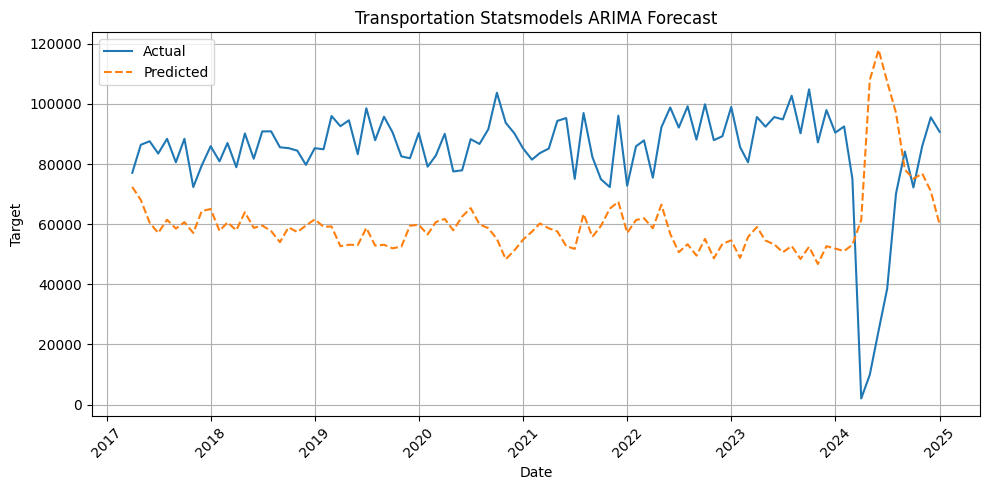

{'Dataset': 'Transportation',
 'Model': 'Statsmodels ARIMA',
 'Target': 'Total TEUs',
 'RMSE': 35113.04811843621,
 'MSE': 1232926148.1676164,
 'MAE': 31772.7468878225,
 'MAPE': 79.0113849513532,
 'R²': -3.7943478742212102,
 'Adj_R²': -4.066754003438325,
 'TrainingTime_s': 2.8801236152648926,
 'TestRatio': 0.3,
 'Device': 'CPU',
 'FinalMemoryMB': 481.484375}

In [8]:
# Run ARIMA Model on Transportation Data

# Define parameters for ARIMA model
transportation_data.name = "Transportation"
target = 'Total TEUs'
date_col = 'Month'  # Column name for the date
test_ratio = 0.3  # Proportion of data to use for testing
engine = "statsmodels" # Engine to use for ARIMA model
order=None  # ARIMA order (p, d, q)

transportation_arima_results = run_arima_on_dataset(
    transportation_data,
    target,
    date_col,
    test_ratio,
    engine,
    order
)

transportation_arima_results

In [9]:
climate_data = pd.read_csv('../data/dataset_climate/raw/Temperature Data with Lag Features of California.csv')
# climate_data = climate_data.dropna()

# Keep only numeric columns
numeric_df = climate_data.select_dtypes(include=[np.number])

# Reattach timestamp
numeric_df['TIME'] = climate_data['TIME'].values

# Set the cleaned DataFrame back
climate_data = numeric_df

climate_data

,Mean_Temperature,lag_1,lag_12,TIME
0,7.268098,10.869001,9.869529,1982-01
1,11.191716,7.268098,11.723992,1982-02
2,10.333570,11.191716,11.615960,1982-03
3,12.718684,10.333570,14.036708,1982-04
4,16.057082,12.718684,16.333115,1982-05
...,...,...,...,...
29749,18.278763,14.200448,17.536118,2024-05
29750,23.837745,18.278763,20.671493,2024-06
29751,28.044864,23.837745,26.447245,2024-07
29752,24.305265,28.044864,25.642810,2024-08


[Before Model Training] Memory Usage: 485.28 MB | Peak Memory Usage: 596.90 MB | CPU Usage: 0.00%
Auto-selecting (p,d,q) using PMDARIMA...


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\d

Selected order: (1, 0, 1)


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is ava

[After Model Training] Memory Usage: 507.32 MB | Peak Memory Usage: 776.64 MB | CPU Usage: 0.00%
Total Training Time: 100.00 seconds
Memory Used (MB): 22.04

[ARIMA - Climate] Evaluation Summary (Statsmodels ARIMA)
---------------------------------------------------------------------------
RMSE                : 1.859
MSE                 : 3.456
MAE                 : 1.470
MAPE (%)            : nan
R²                  : 0.926
Adjusted R²         : 0.926
Training Time (s)   : 100.00
Memory Used (MB)    : 22.04
Device Used         : CPU
---------------------------------------------------------------------------


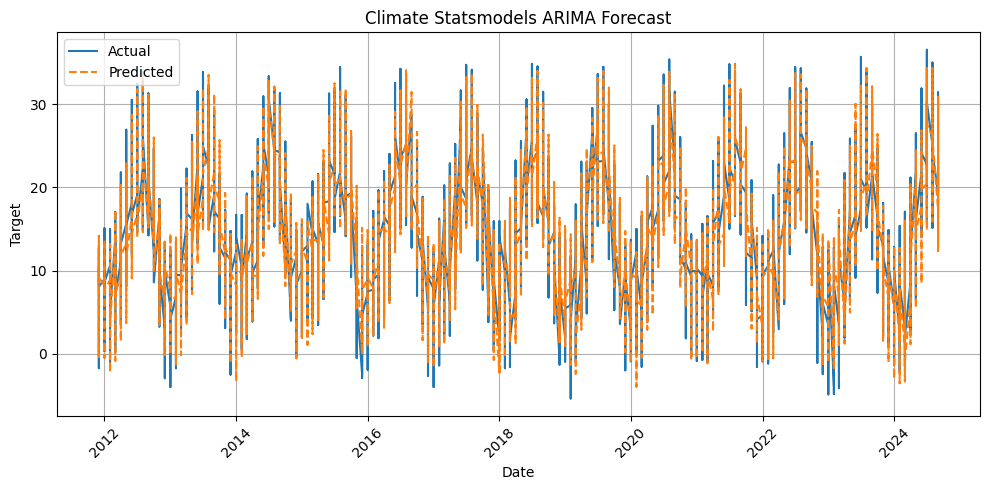

{'Dataset': 'Climate',
 'Model': 'Statsmodels ARIMA',
 'Target': 'Mean_Temperature',
 'RMSE': 1.8590257972768813,
 'MSE': 3.4559769149409445,
 'MAE': 1.4703994713784352,
 'MAPE': nan,
 'R²': 0.9255271153955316,
 'Adj_R²': 0.9255104249238587,
 'TrainingTime_s': 100.00308465957642,
 'TestRatio': 0.3,
 'Device': 'CPU',
 'FinalMemoryMB': 507.31640625}

In [10]:
# Run ARIMA Model on Climate Data

# Define parameters for ARIMA model
climate_data.name = "Climate"
target = 'Mean_Temperature'
date_col = 'TIME'  # Column name for the date
test_ratio = 0.3  # Proportion of data to use for testing
engine = "statsmodels"
order=None  # ARIMA order (p, d, q)

climate_arima_results = run_arima_on_dataset(
    climate_data,
    target,
    date_col,
    test_ratio,
    engine,
    order
)

climate_arima_results

In [27]:
energy_data = pd.read_csv('../data/dataset_energy/df_with_lag_indicators.csv.gz')

# Parse the timestamp with correct format (day/month/year)
energy_data['timestamp'] = pd.to_datetime(energy_data['timestamp'], format='%d/%m/%y %H:%M')
energy_data = energy_data.set_index('timestamp').sort_index()

# Drop initial rows with NaNs from lag/rolling features
energy_data = energy_data.dropna()

# Now check the result
energy_data

,Energy_Demand,Energy_Price,Crude_Oil_Price,Natural_Gas_Price,Rainfall,Carbon_Intensity,Renewable_Energy_Percentage,Temperature,Solar_Exposure,hour,dayofweek,month,lag_1,lag_12,lag_288,lag_576,rolling_mean_24,rolling_std_24
timestamp,,,,,,,,,,,,,,,,,,
2022-01-05 00:00:00,6973.25,5.707044,80.60,3.78,3.8,399.25,46.48,23,0,0,2,1,4.912655,4.845682,4.614823,4.370966,5.409152,0.343915
2022-01-05 00:05:00,6973.88,5.707077,80.60,3.78,3.8,399.25,46.48,23,0,0,2,1,5.707044,5.218625,5.295714,4.507557,5.419512,0.349168
2022-01-05 00:10:00,7025.21,5.707044,80.60,3.78,3.8,399.25,46.48,23,0,0,2,1,5.707077,5.252273,5.282340,4.476996,5.421114,0.350446
2022-01-05 00:15:00,6998.04,5.707044,80.60,3.78,3.8,399.25,46.48,23,0,0,2,1,5.707044,5.707044,5.673255,4.497028,5.422370,0.351456
2022-01-05 00:20:00,6890.58,5.707044,80.60,3.78,3.8,399.25,46.48,22,0,0,2,1,5.707044,4.912655,5.504722,4.478132,5.423956,0.352701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:40:00,7467.70,4.900523,74.58,3.40,0.0,202.82,73.07,22,0,23,1,12,4.894326,4.730392,4.900820,4.686934,4.736257,0.093819
2024-12-31 23:45:00,7393.27,4.967171,74.58,3.40,0.0,202.82,73.07,22,0,23,1,12,4.900523,4.715459,4.817455,4.478132,4.745846,0.098441
2024-12-31 23:50:00,7360.53,4.888091,74.58,3.40,0.0,202.82,73.07,22,0,23,1,12,4.967171,4.721797,4.730304,4.590564,4.758698,0.106386


In [ ]:
# Run ARIMA Model on Energy Data

# Define parameters for ARIMA model
target = 'Energy_Demand'  # Target variable to predict
energy_data = energy_data.reset_index()
date_col = 'timestamp'  # Column name for the date
energy_data.name = "Energy"
test_ratio = 0.3  # Proportion of data to use for testing
engine = 'statsmodels'
order = None

energy_arima_results = run_arima_on_dataset(
    energy_data,
    target,
    date_col,
    test_ratio,
    engine,
    order
)

energy_arima_results

[Before Model Training] Memory Usage: 656.81 MB | Peak Memory Usage: 10760.78 MB | CPU Usage: 0.00%
Auto-selecting (p,d,q) using PMDARIMA...


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\d

In [ ]:
# Step 1: Collect all result dictionaries
all_results = [
    finance_arima_results,
    retail_arima_results,
    climate_arima_results,
    energy_arima_results,
    transportation_arima_results
]

# Step 2: Convert to DataFrame
metrics_df = pd.DataFrame(all_results)
metrics_df.set_index('Dataset', inplace=True)

# Step 3: Save to CSV
output_path = "outputs/results/output_ARIMA/model_metrics_scores.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
metrics_df.to_csv(output_path)

# Step 4: Display
print(f"Metrics collected and saved to:\n{output_path}")
metrics_df

Metrics collected and saved to:
outputs/results/output_ARIMA/model_metrics_scores.csv


,Model,Target,RMSE,MSE,MAE,MAPE,R²,Adj_R²,TrainingTime_s,TestRatio,Device,FinalMemoryMB
Dataset,,,,,,,,,,,,
Finance,Statsmodels ARIMA,Close_TSLA,25.953966,6.736083e+02,24.022786,NaN,0.795197,0.768582,17.477581,0.3,CPU,470.105469
Retail,Statsmodels ARIMA,sales,130.167586,1.694360e+04,107.860323,604.871661,-369.767192,-415.478215,17.744736,0.3,CPU,475.031250
Climate,Statsmodels ARIMA,Mean_Temperature,2.049591,4.200823e+00,1.664078,NaN,0.909476,0.909456,7.838133,0.3,CPU,592.781250
Energy,Statsmodels ARIMA,Energy_Demand,1496.461092,2.239396e+06,1277.900604,NaN,-0.234588,-0.234825,1174.034594,0.3,CPU,1229.125000
Transportation,Statsmodels ARIMA,Total TEUs,34826.931027,1.212915e+09,31660.424530,77.569738,-3.716533,-3.984518,0.446237,0.3,CPU,475.191406


In [ ]:
#	Step 5: Plotting

# Load the metrics CSV if it exists
metrics_path = "outputs/results/output_ARIMA/model_metrics_scores.csv"
metrics_df = pd.read_csv(metrics_path)
metrics_df.set_index('Dataset', inplace=True)

# Plot comparison charts for each metric
metrics_to_plot = ["RMSE", "MAE", "MAPE", "R²", "Adj_R²", "TrainingTime_s", "FinalMemoryMB"]
figures = {}

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    metrics_df[metric].plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"{metric} Comparison Across Datasets")
    plt.ylabel(metric)
    plt.xlabel("Dataset")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the figure
    fig_path = f"outputs/results/output_ARIMA/{metric}_comparison.png"
    os.makedirs(os.path.dirname(fig_path), exist_ok=True)
    plt.savefig(fig_path)
    figures[metric] = fig_path
    
    # Show the figure
    plt.show()

figures

# Step 6: Standardize metric column names
metrics_df.rename(columns={
    'RMSE': 'rmse',
    'MSE': 'mse',
    'MAE': 'mae',
    'MAPE': 'mape',
    'R²': 'r2',
    'Adj_R²': 'adj_r2'
}, inplace=True)

# Optional: add model name column if needed
if 'model_name' not in metrics_df.columns:
    metrics_df['model_name'] = metrics_df.index

# Step 7: Heatmaps by Dataset (rows) × model_name (columns)
plot_heatmap(metrics_df.reset_index())

#### Univariate Input for Single Output

[Before Model Training] Memory Usage: 835.52 MB | Peak Memory Usage: 836.95 MB | CPU Usage: 0.00%


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is ava

[After Model Training] Memory Usage: 836.02 MB | Peak Memory Usage: 836.95 MB | CPU Usage: 0.00%
Total Training Time: 0.62 seconds
Memory Used (MB): 0.50

[ARIMA - Finance] Evaluation Summary (Statsmodels ARIMA)
---------------------------------------------------------------------------
RMSE                : 60.171
MSE                 : 3620.502
MAE                 : 46.044
MAPE (%)            : nan
R²                  : -0.101
Adjusted R²         : -0.101
Training Time (s)   : 0.62
Memory Used (MB)    : 0.50
Device Used         : CPU
---------------------------------------------------------------------------


c:\Users\gnniv\Documents\NUS Msc In Data Science in Sustainability\DSS5104 Machine Learning and Predictive Modelling\CA2\ProjectFiles\GitHub\DSS5104-ForecastDL\src\models\base_ARIMA.py:145: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100


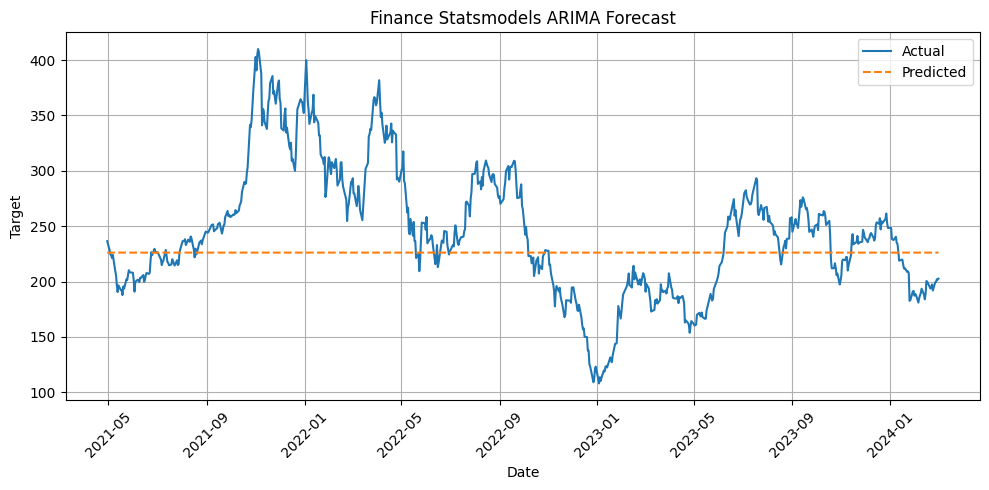

{'Dataset': 'Finance',
 'Model': 'Statsmodels ARIMA',
 'Target': 'Close_TSLA',
 'RMSE': 60.1706106539805,
 'MSE': 3620.502386472912,
 'MAE': 46.04364637883851,
 'MAPE': nan,
 'R²': -0.10077233824485177,
 'Adj_R²': -0.10077233824485177,
 'TrainingTime_s': 0.6174807548522949,
 'TestRatio': 0.3,
 'Device': 'CPU',
 'FinalMemoryMB': 836.01953125}

In [16]:
# Run ARIMA Model on Finance Data

# Define parameters for ARIMA model
target = "Close_TSLA"  # Target variable to predict
date_col = "Date"  # Column name for the date
data = finance_data[[date_col, target]]
data.name = "Finance"
test_ratio = 0.3  # Proportion of data to use for testing
engine = "statsmodels" # Engine to use for ARIMA model # or "pmdarima"
order=(1, 1, 1)  # ARIMA order (p, d, q)

finance_arima_results_1 = run_arima_on_dataset(
    data,
    target,
    date_col,
    test_ratio,
    engine,  
    order
)

finance_arima_results_1

[Before Model Training] Memory Usage: 836.21 MB | Peak Memory Usage: 841.81 MB | CPU Usage: 0.00%
[After Model Training] Memory Usage: 836.23 MB | Peak Memory Usage: 841.81 MB | CPU Usage: 0.00%
Total Training Time: 0.51 seconds
Memory Used (MB): 0.03

[ARIMA - Retail] Evaluation Summary (Statsmodels ARIMA)
---------------------------------------------------------------------------
RMSE                : 6.937
MSE                 : 48.121
MAE                 : 5.601
MAPE (%)            : 32.591
R²                  : -0.032
Adjusted R²         : -0.032
Training Time (s)   : 0.51
Memory Used (MB)    : 0.03
Device Used         : CPU
---------------------------------------------------------------------------


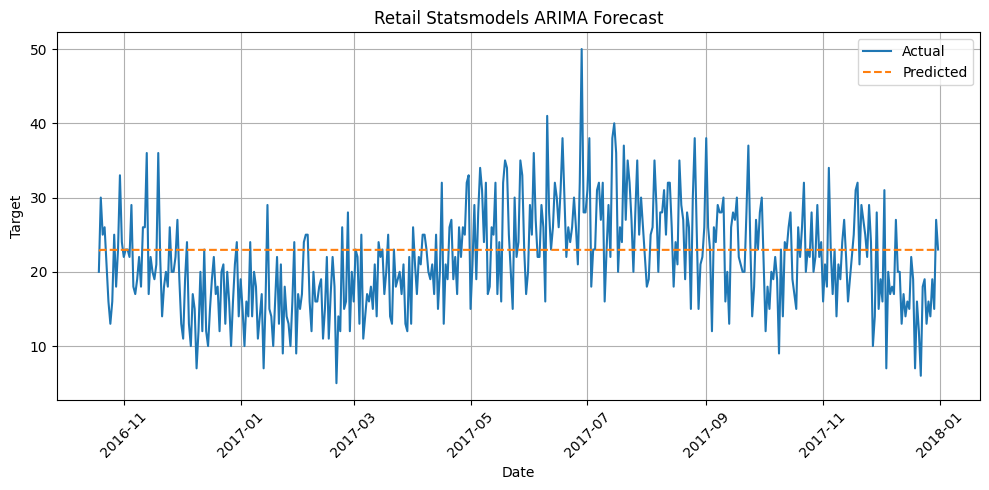

{'Dataset': 'Retail',
 'Model': 'Statsmodels ARIMA',
 'Target': 'sales',
 'RMSE': 6.936927115142497,
 'MSE': 48.12095780079921,
 'MAE': 5.601135518041621,
 'MAPE': 32.59115230589346,
 'R²': -0.031503406340900986,
 'Adj_R²': -0.031503406340900986,
 'TrainingTime_s': 0.5087146759033203,
 'TestRatio': 0.3,
 'Device': 'CPU',
 'FinalMemoryMB': 836.234375}

In [17]:
# Run ARIMA Model on Retail Data

# Define parameters for ARIMA model
target = 'sales'  # Target variable to predict
date_col = 'date'  # Column name for the date
data = retail_data[[date_col, target]]
data.name = "Retail"
test_ratio = 0.3  # Proportion of data to use for testing
engine = "statsmodels" # Engine to use for ARIMA model # or "pmdarima"
order=(1, 1, 1)  # ARIMA order (p, d, q)

retail_arima_results_1 = run_arima_on_dataset(
    data,
    target,
    date_col,
    test_ratio,
    engine,  
    order
)

retail_arima_results_1

c:\Users\gnniv\Documents\NUS Msc In Data Science in Sustainability\DSS5104 Machine Learning and Predictive Modelling\CA2\ProjectFiles\GitHub\DSS5104-ForecastDL\src\models\base_ARIMA.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce')


[Before Model Training] Memory Usage: 836.26 MB | Peak Memory Usage: 841.87 MB | CPU Usage: 0.00%
[After Model Training] Memory Usage: 836.26 MB | Peak Memory Usage: 841.87 MB | CPU Usage: 0.00%
Total Training Time: 0.57 seconds
Memory Used (MB): 0.00

[ARIMA - Transportation] Evaluation Summary (Statsmodels ARIMA)
---------------------------------------------------------------------------
RMSE                : 20195.903
MSE                 : 407874488.575
MAE                 : 16869.886
MAPE (%)            : 62.084
R²                  : -0.586
Adjusted R²         : -0.586
Training Time (s)   : 0.57
Memory Used (MB)    : 0.00
Device Used         : CPU
---------------------------------------------------------------------------


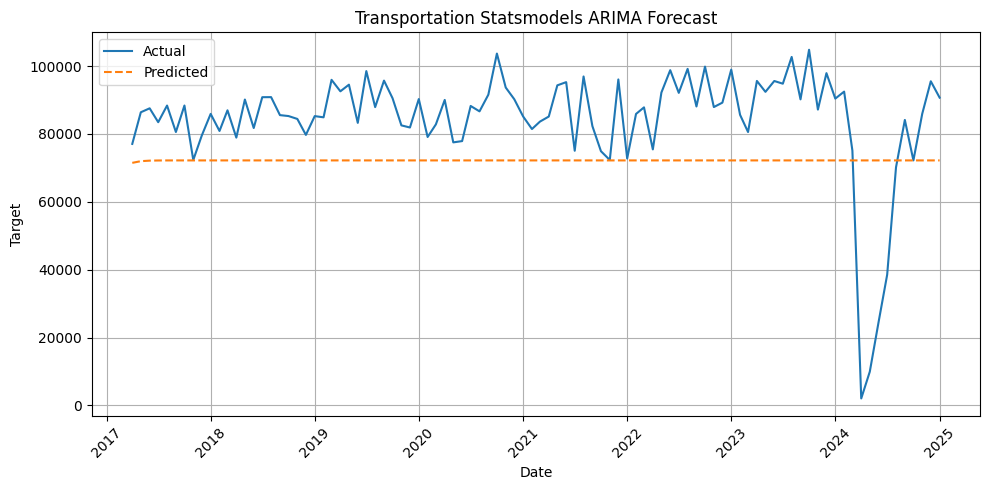

{'Dataset': 'Transportation',
 'Model': 'Statsmodels ARIMA',
 'Target': 'Total TEUs',
 'RMSE': 20195.9027670229,
 'MSE': 407874488.5750433,
 'MAE': 16869.88614304376,
 'MAPE': 62.08439875275125,
 'R²': -0.5860578430874297,
 'Adj_R²': -0.5860578430874295,
 'TrainingTime_s': 0.5722627639770508,
 'TestRatio': 0.3,
 'Device': 'CPU',
 'FinalMemoryMB': 836.26171875}

In [18]:
# Run ARIMA Model on Transportation Data

# Define parameters for ARIMA model
target = 'Total TEUs'
date_col = 'Month'  # Column name for the date
data = transportation_data[[date_col, target]]
data.name = "Transportation"
test_ratio = 0.3  # Proportion of data to use for testing
engine = "statsmodels" # Engine to use for ARIMA model
order=(1, 1, 1)  # ARIMA order (p, d, q)

transportation_arima_results_1 = run_arima_on_dataset(
    data,
    target,
    date_col,
    test_ratio,
    engine,
    order
)

transportation_arima_results_1

[Before Model Training] Memory Usage: 837.25 MB | Peak Memory Usage: 841.88 MB | CPU Usage: 0.00%


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is ava

[After Model Training] Memory Usage: 874.43 MB | Peak Memory Usage: 874.43 MB | CPU Usage: 0.00%
Total Training Time: 2.87 seconds
Memory Used (MB): 37.18

[ARIMA - Climate] Evaluation Summary (Statsmodels ARIMA)
---------------------------------------------------------------------------
RMSE                : 10.463
MSE                 : 109.478
MAE                 : 8.676
MAPE (%)            : nan
R²                  : -1.359
Adjusted R²         : -1.359
Training Time (s)   : 2.87
Memory Used (MB)    : 37.18
Device Used         : CPU
---------------------------------------------------------------------------


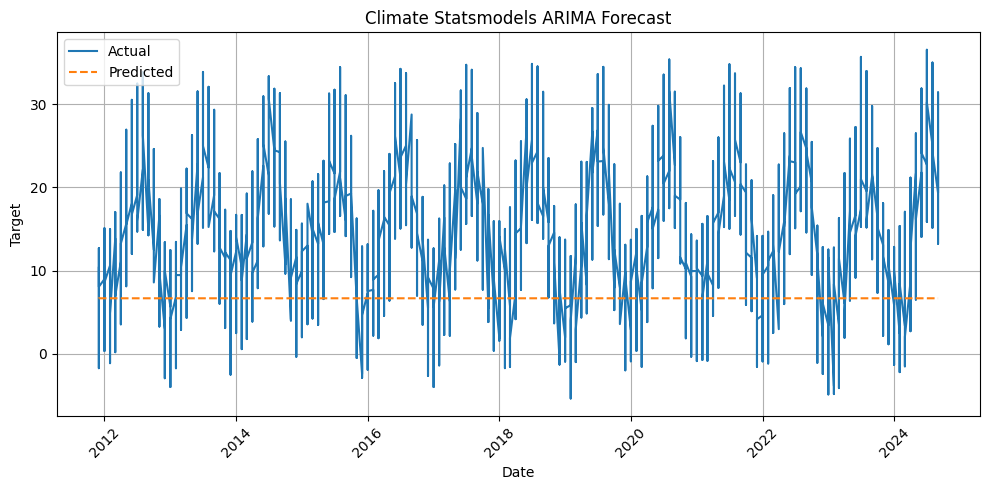

{'Dataset': 'Climate',
 'Model': 'Statsmodels ARIMA',
 'Target': 'Mean_Temperature',
 'RMSE': 10.463151078622055,
 'MSE': 109.47753049406985,
 'MAE': 8.676210350695545,
 'MAPE': nan,
 'R²': -1.3591325104109857,
 'Adj_R²': -1.3591325104109857,
 'TrainingTime_s': 2.865987539291382,
 'TestRatio': 0.3,
 'Device': 'CPU',
 'FinalMemoryMB': 874.4296875}

In [19]:
# Run ARIMA Model on Climate Data

# Define parameters for ARIMA model
target = 'Mean_Temperature'
date_col = 'TIME'  # Column name for the date
data = climate_data[[date_col, target]]
data.name = "Climate"
test_ratio = 0.3  # Proportion of data to use for testing
engine = "statsmodels"
order=(1, 1, 1)  # ARIMA order (p, d, q)

climate_arima_results_1 = run_arima_on_dataset(
    data,
    target,
    date_col,
    test_ratio,
    engine,
    order
)

climate_arima_results_1


[Before Model Training] Memory Usage: 1262.10 MB | Peak Memory Usage: 7633.19 MB | CPU Usage: 0.00%


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

[After Model Training] Memory Usage: 1611.42 MB | Peak Memory Usage: 7633.19 MB | CPU Usage: 0.00%
Total Training Time: 50.36 seconds
Memory Used (MB): 349.32


c:\Users\gnniv\Documents\NUS Msc In Data Science in Sustainability\DSS5104 Machine Learning and Predictive Modelling\CA2\ProjectFiles\GitHub\DSS5104-ForecastDL\src\models\base_ARIMA.py:145: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100



[ARIMA - Energy] Evaluation Summary (Statsmodels ARIMA)
---------------------------------------------------------------------------
RMSE                : 1422.511
MSE                 : 2023536.155
MAE                 : 1166.627
MAPE (%)            : nan
R²                  : -0.134
Adjusted R²         : -0.134
Training Time (s)   : 50.36
Memory Used (MB)    : 349.32
Device Used         : CPU
---------------------------------------------------------------------------


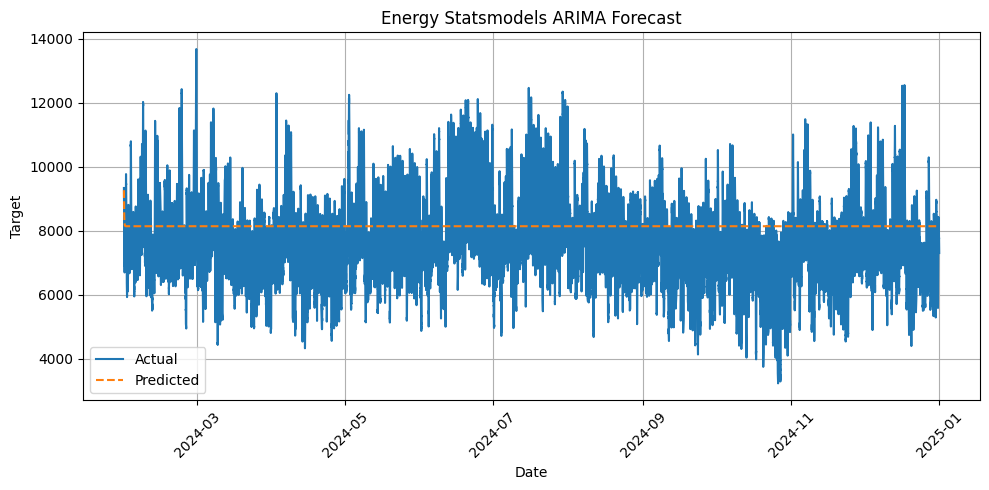

{'Dataset': 'Energy',
 'Model': 'Statsmodels ARIMA',
 'Target': 'Energy_Demand',
 'RMSE': 1422.5105113740779,
 'MSE': 2023536.1549697402,
 'MAE': 1166.6266949574524,
 'MAPE': nan,
 'R²': -0.13432084109913234,
 'Adj_R²': -0.13432084109913234,
 'TrainingTime_s': 50.35607838630676,
 'TestRatio': 0.3,
 'Device': 'CPU',
 'FinalMemoryMB': 1611.41796875}

In [23]:
# Run ARIMA Model on Energy Data

# Define parameters for ARIMA model
target = 'Energy_Demand'  # Target variable to predict
date_col = 'timestamp'  # Column name for the date
data = energy_data[[target, date_col]]
data.name = "Energy"
test_ratio = 0.3  # Proportion of data to use for testing
engine = 'statsmodels'
order = (1, 1, 1)

energy_arima_results_1 = run_arima_on_dataset(
    data,
    target,
    date_col,
    test_ratio,
    engine,
    order
)

energy_arima_results_1

Metrics collected and saved to:
outputs/results/output_ARIMA/model_metrics_scores_1.csv
                            Model            Target          RMSE  \
Dataset                                                             
Finance         Statsmodels ARIMA        Close_TSLA     60.170611   
Retail          Statsmodels ARIMA             sales      6.936927   
Climate         Statsmodels ARIMA  Mean_Temperature     10.463151   
Energy          Statsmodels ARIMA     Energy_Demand   1422.510511   
Transportation  Statsmodels ARIMA        Total TEUs  20195.902767   

                         MSE           MAE       MAPE        R²    Adj_R²  \
Dataset                                                                     
Finance         3.620502e+03     46.043646        NaN -0.100772 -0.100772   
Retail          4.812096e+01      5.601136  32.591152 -0.031503 -0.031503   
Climate         1.094775e+02      8.676210        NaN -1.359133 -1.359133   
Energy          2.023536e+06   1166.626695 

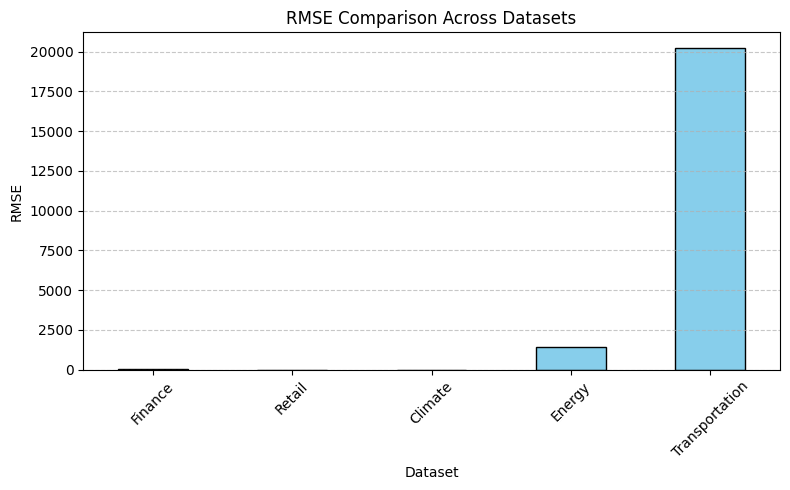

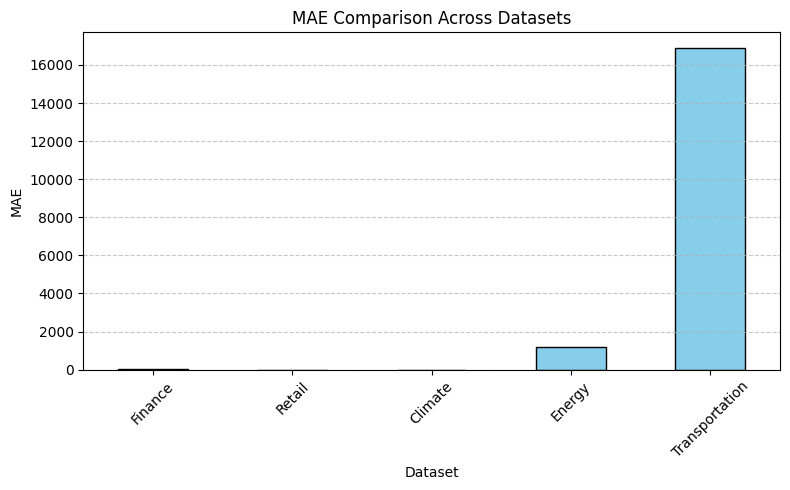

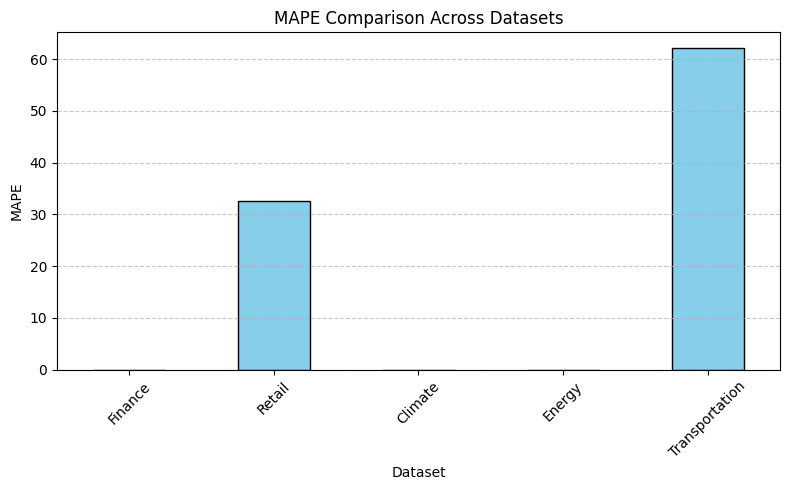

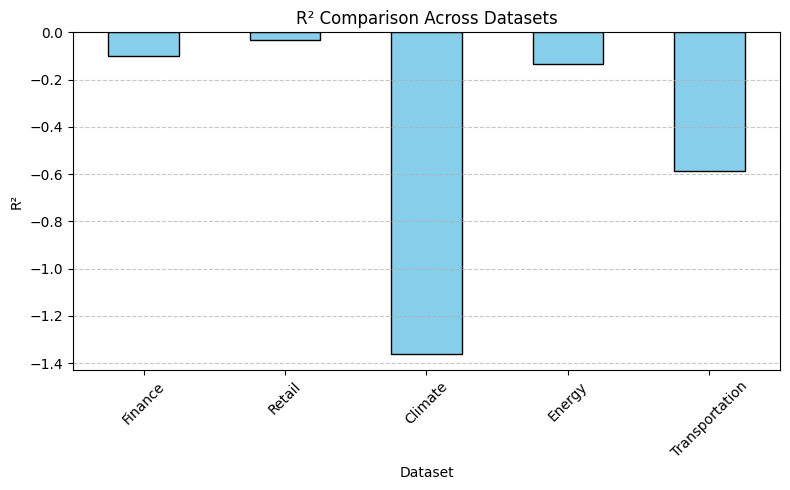

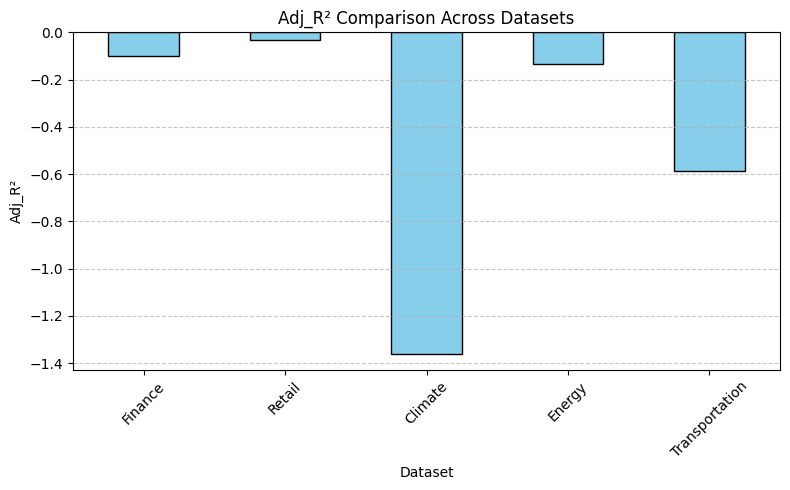

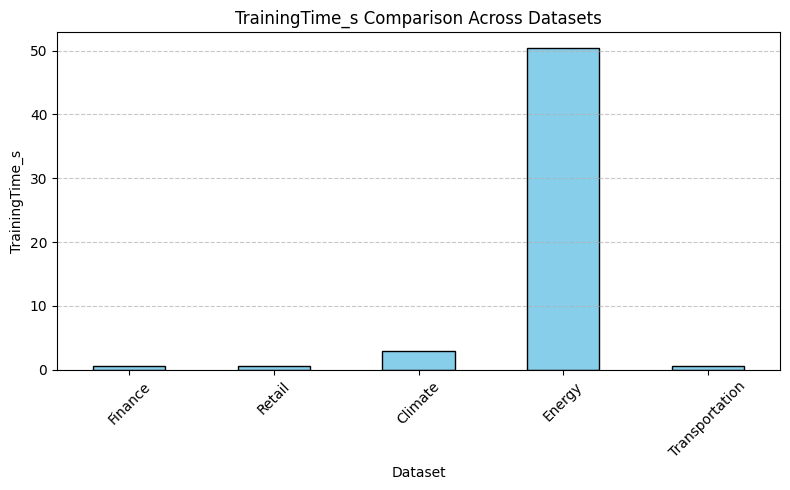

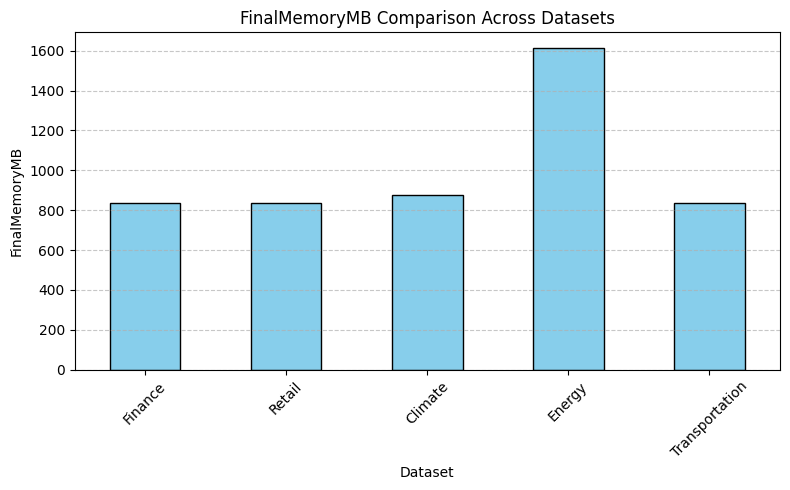

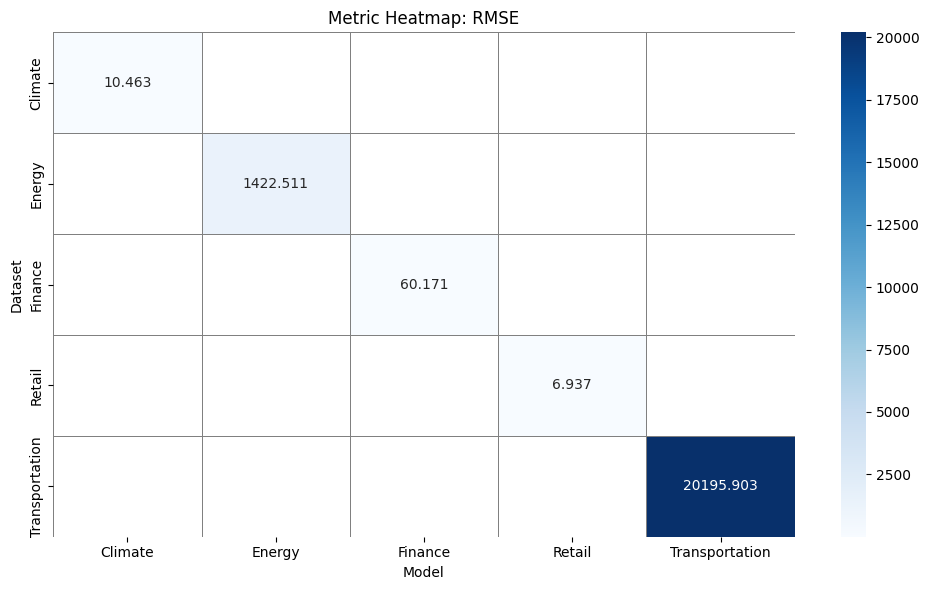

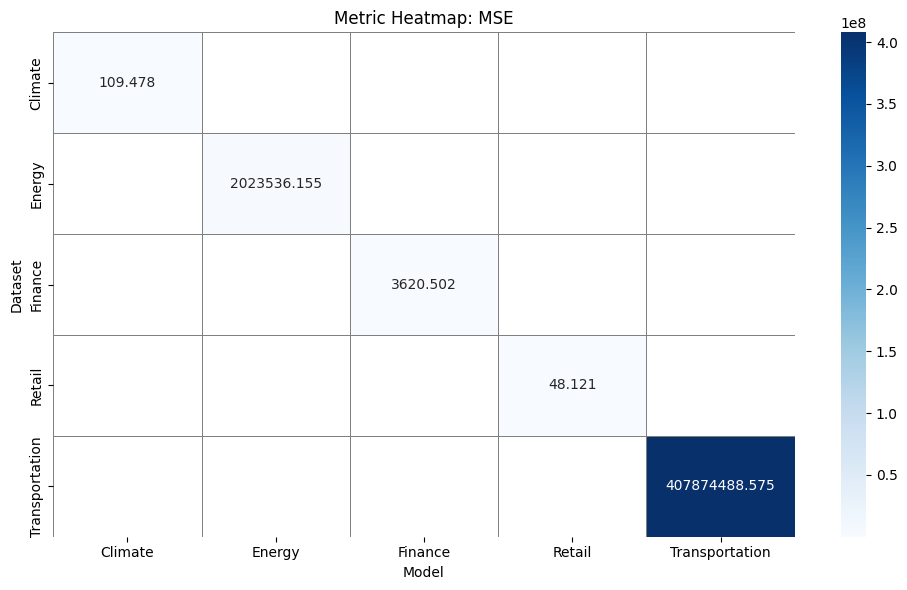

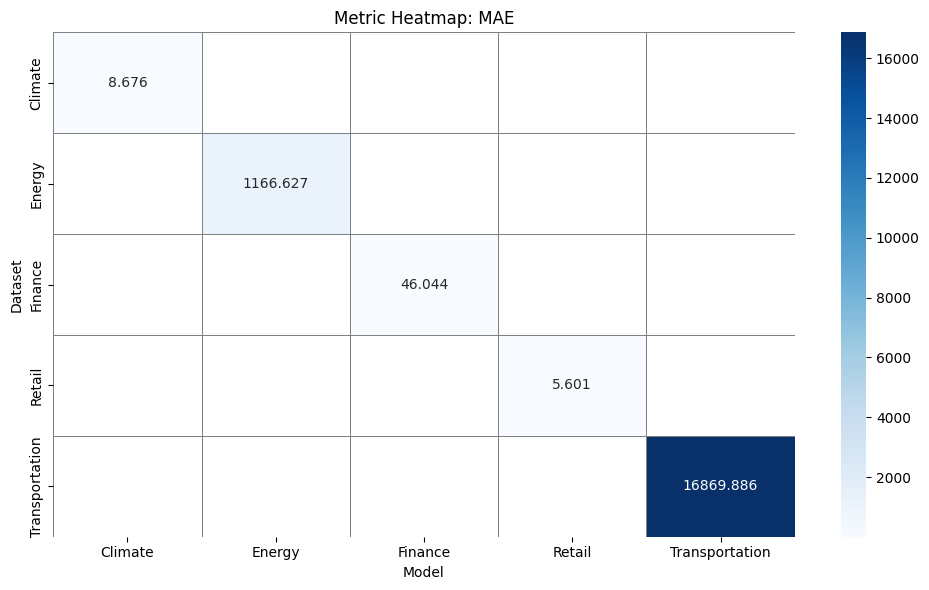

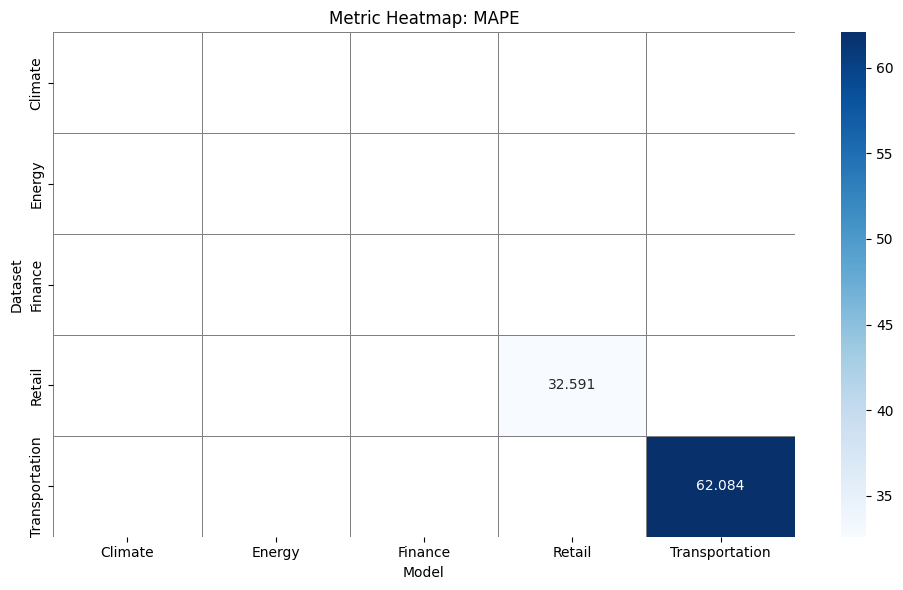

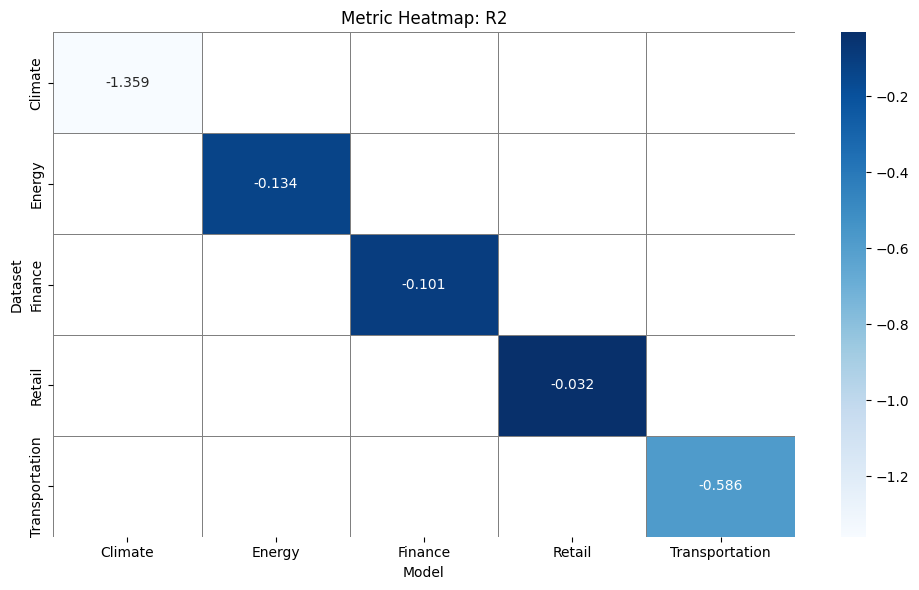

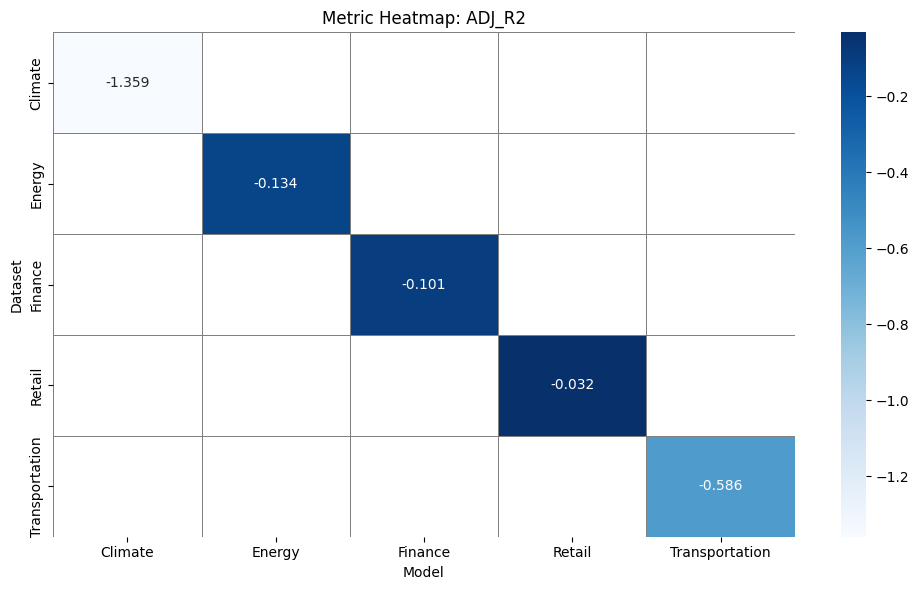

In [24]:
# Step 1: Collect all result dictionaries
all_results = [
    finance_arima_results_1,
    retail_arima_results_1,
    climate_arima_results_1,
    energy_arima_results_1,
    transportation_arima_results_1
]

# Step 2: Convert to DataFrame
metrics_df = pd.DataFrame(all_results)
metrics_df.set_index('Dataset', inplace=True)

# Step 3: Save to CSV
output_path = "outputs/results/output_ARIMA/model_metrics_scores_1.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
metrics_df.to_csv(output_path)

# Step 4: Display
print(f"Metrics collected and saved to:\n{output_path}")
print(metrics_df)

#	Step 5: Plotting

# Load the metrics CSV if it exists
metrics_path = "outputs/results/output_ARIMA/model_metrics_scores_1.csv"
metrics_df = pd.read_csv(metrics_path)
metrics_df.set_index('Dataset', inplace=True)

# Plot comparison charts for each metric
metrics_to_plot = ["RMSE", "MAE", "MAPE", "R²", "Adj_R²", "TrainingTime_s", "FinalMemoryMB"]
figures = {}

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    metrics_df[metric].plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"{metric} Comparison Across Datasets")
    plt.ylabel(metric)
    plt.xlabel("Dataset")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the figure
    fig_path = f"outputs/results/output_ARIMA/{metric}_comparison_1.png"
    os.makedirs(os.path.dirname(fig_path), exist_ok=True)
    plt.savefig(fig_path)
    figures[metric] = fig_path
    
    # Show the figure
    plt.show()

figures

# Step 6: Standardize metric column names
metrics_df.rename(columns={
    'RMSE': 'rmse',
    'MSE': 'mse',
    'MAE': 'mae',
    'MAPE': 'mape',
    'R²': 'r2',
    'Adj_R²': 'adj_r2'
}, inplace=True)

# Optional: add model name column if needed
if 'model_name' not in metrics_df.columns:
    metrics_df['model_name'] = metrics_df.index

# Step 7: Heatmaps by Dataset (rows) × model_name (columns)
plot_heatmap(metrics_df.reset_index())

In [ ]:
# import os
# import sys
# import importlib

# # Add one level up to sys.path if not already added
# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# # First, import the full module (not just the function)
# import src.models.base_ARIMA

# # Now reload it
# importlib.reload(src.models.base_ARIMA)

# # Re-import the specific function you want (after reload)
# from src.models.base_ARIMA import run_arima_on_dataset


In [ ]:
metrics_df

,Model,Target,rmse,mse,mae,mape,r2,adj_r2,TrainingTime_s,TestRatio,Device,FinalMemoryMB,model_name
Dataset,,,,,,,,,,,,,
Finance,Statsmodels ARIMA,Close_TSLA,60.283651,3.634119e+03,46.120436,NaN,-0.104912,-0.104912,0.569502,0.3,CPU,140.988281,Finance
Retail,Statsmodels ARIMA,sales,7.242436,5.245288e+01,5.901441,35.618367,-0.124361,-0.124361,0.444909,0.3,CPU,140.589844,Retail
Climate,Statsmodels ARIMA,Mean_Temperature,11.205490,1.255630e+02,9.432713,NaN,-1.705759,-1.705759,2.018441,0.3,CPU,259.199219,Climate
Energy,Statsmodels ARIMA,Energy_Demand,2017.121075,4.068777e+06,1761.338516,NaN,-1.237454,-1.237454,16.192548,0.3,CPU,1290.695312,Energy
Transportation,Statsmodels ARIMA,Total TEUs,21197.877581,4.493500e+08,18288.330987,62.682381,-0.747339,-0.747339,0.147978,0.3,CPU,145.320312,Transportation


In [22]:
import gc
gc.collect()

import tensorflow as tf
tf.keras.backend.clear_session()